In [89]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [114]:
# (re-)load layers
%run dnn_modules.ipynb

In [91]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

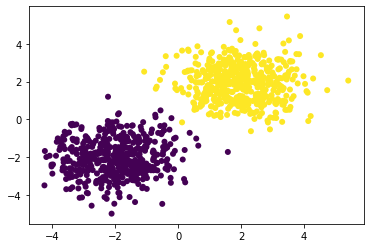

In [92]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [93]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = MSECriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [94]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [107]:
from sklearn.metrics import accuracy_score

def train(X, Y, net, optimizer_config, optimizer_state, batch_size, n_epoch):
    loss_history = []
    accuracy_history = []

    for i in range(n_epoch):
        epoch_loss_history = []
        epoch_accuracy_history = []
        
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            
            # accuracy
            binary_predictions = [np.where(pred==np.max(pred), 1, 0) for pred in predictions]
            accuracy = accuracy_score(y_batch, binary_predictions)
            
            # loss
            loss = criterion.forward(predictions, y_batch)
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
            epoch_loss_history.append(loss)
            epoch_accuracy_history.append(accuracy)
            
        loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
        accuracy_history.append(sum(epoch_accuracy_history) / len(epoch_accuracy_history))
        
        print('Current epoch: %i' % (i + 1))
        print('Current loss: %f' % loss)
        print('Current accuracy: %f' % accuracy)
    
    return loss_history, accuracy_history

def train_with_test(X, Y, X_test, Y_test, net, optimizer_config, optimizer_state, batch_size, n_epoch):
    loss_history = []
    accuracy_history = []
    test_loss_h = []
    test_accuracy_h = []

    for i in range(n_epoch):
        epoch_loss_history = []
        epoch_accuracy_history = []
        
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            
            # accuracy
            binary_predictions = [np.where(pred==np.max(pred), 1, 0) for pred in predictions]
            accuracy = accuracy_score(y_batch, binary_predictions)
            
            # loss
            loss = criterion.forward(predictions, y_batch)
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
            epoch_loss_history.append(loss)
            epoch_accuracy_history.append(accuracy)
            
        loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
        accuracy_history.append(sum(epoch_accuracy_history) / len(epoch_accuracy_history))
        
        # test the model
        test_predict = net.forward(X_test)
        
        # test accuracy
        binary_test_predict = [np.where(pred==np.max(pred), 1, 0) for pred in test_predict]
        test_accuracy = accuracy_score(Y_test, binary_test_predict)
        
        # test loss
        test_loss = criterion.forward(test_predict, Y_test)
        
        test_loss_h.append(test_loss)
        test_accuracy_h.append(test_accuracy)
        
        print('Current epoch: %i' % (i + 1))
        print('Current loss: %f' % loss)
        print('Current accuracy: %f' % accuracy)
        print('Current test loss: %f' % test_loss)
        print('Current test accuracy: %f' % test_accuracy)
    
    return loss_history, accuracy_history, test_loss_h, test_accuracy_h

Current epoch: 1
Current loss: 0.078991
Current accuracy: 0.942308
Current epoch: 2
Current loss: 0.002465
Current accuracy: 1.000000
Current epoch: 3
Current loss: 0.000042
Current accuracy: 1.000000
Current epoch: 4
Current loss: 0.000454
Current accuracy: 1.000000
Current epoch: 5
Current loss: 0.001122
Current accuracy: 1.000000
Current epoch: 6
Current loss: 0.000273
Current accuracy: 1.000000
Current epoch: 7
Current loss: 0.000054
Current accuracy: 1.000000
Current epoch: 8
Current loss: 0.000178
Current accuracy: 1.000000
Current epoch: 9
Current loss: 0.000076
Current accuracy: 1.000000
Current epoch: 10
Current loss: 0.000013
Current accuracy: 1.000000
Current epoch: 11
Current loss: 0.000027
Current accuracy: 1.000000
Current epoch: 12
Current loss: 0.000016
Current accuracy: 1.000000
Current epoch: 13
Current loss: 0.000053
Current accuracy: 1.000000
Current epoch: 14
Current loss: 0.006222
Current accuracy: 0.990385
Current epoch: 15
Current loss: 0.001288
Current accuracy

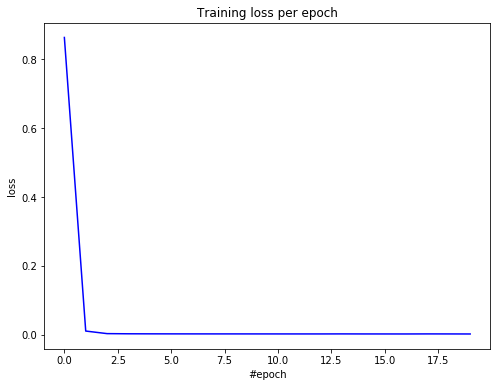

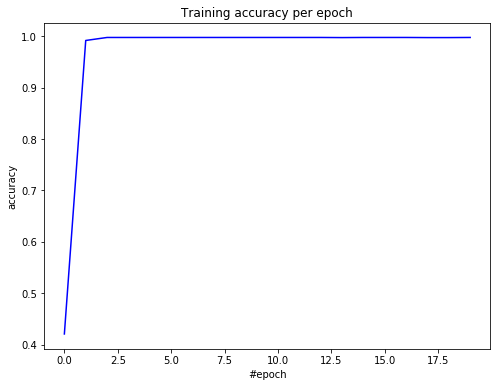

In [96]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# train toy net model
train_loss, train_accuracy = train(X, Y, net, optimizer_config, optimizer_state, batch_size, n_epoch)

# Visualize loss
plt.figure(figsize=(8, 6))

plt.title("Training loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss, 'b')
plt.show()

# Visualize accuracy
plt.figure(figsize=(8, 6))

plt.title("Training accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy, 'b')
plt.show()

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [97]:
import os
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [98]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() 
y_one_hot = encoder.fit_transform(y.reshape(-1, 1)).toarray()

print(X.shape)
print(y_one_hot.shape)

(70000, 784)
(70000, 10)


In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.33, random_state=42, shuffle=True)

print(np.shape(X_train))
print(np.shape(y_test))

(46900, 784)
(23100, 10)


## Simple neural network (1 Linear + SoftMax)

Current epoch: 1
Current loss: 0.187082
Current accuracy: 0.900000
Current test loss: 0.231240
Current test accuracy: 0.865974
Current epoch: 2
Current loss: 0.164446
Current accuracy: 0.890000
Current test loss: 0.191653
Current test accuracy: 0.882208
Current epoch: 3
Current loss: 0.135949
Current accuracy: 0.930000
Current test loss: 0.175374
Current test accuracy: 0.891255
Current epoch: 4
Current loss: 0.195110
Current accuracy: 0.880000
Current test loss: 0.166392
Current test accuracy: 0.895887
Current epoch: 5
Current loss: 0.142351
Current accuracy: 0.920000
Current test loss: 0.159808
Current test accuracy: 0.899177
Current epoch: 6
Current loss: 0.129366
Current accuracy: 0.950000
Current test loss: 0.155444
Current test accuracy: 0.901082
Current epoch: 7
Current loss: 0.205886
Current accuracy: 0.860000
Current test loss: 0.151838
Current test accuracy: 0.903723
Current epoch: 8
Current loss: 0.129130
Current accuracy: 0.910000
Current test loss: 0.148940
Current test acc

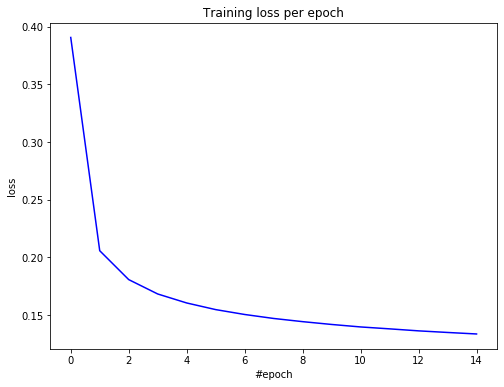

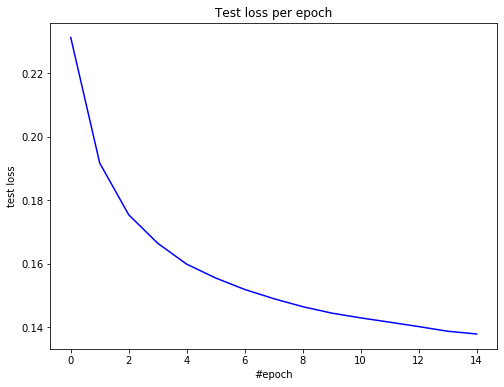

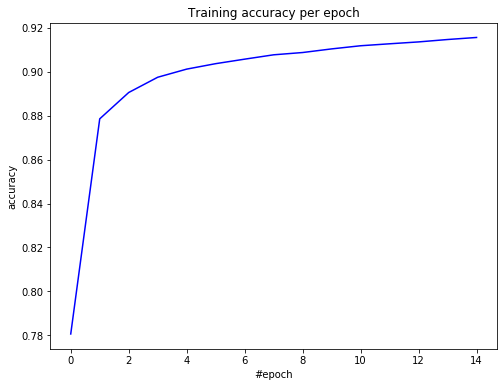

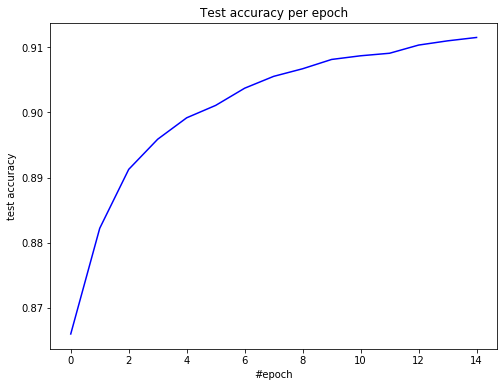

In [109]:
my_nn_1 = Sequential()
my_nn_1.add(Linear(784, 10))
my_nn_1.add(SoftMax())

criterion = MSECriterion()

optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

batch_size = 120
epoch_number = 15

# train and test the model
train_loss, train_acc, test_loss, test_acc = train_with_test(X_train, y_train, X_test, y_test, my_nn_1, optimizer_config, optimizer_state, batch_size, epoch_number)

# Visualize loss
plt.figure(figsize=(8, 6))

plt.title("Training loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss, 'b')
plt.show()

# test loss
plt.figure(figsize=(8, 6))

plt.title("Test loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("test loss")
plt.plot(test_loss, 'b')
plt.show()

# Visualize accuracy
plt.figure(figsize=(8, 6))

plt.title("Training accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_acc, 'b')
plt.show()

plt.figure(figsize=(8, 6))

plt.title("Test accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("test accuracy")
plt.plot(test_acc, 'b')
plt.show()

## NN with several hidden layers

Current epoch: 1
Current loss: 0.206774
Current accuracy: 0.860000
Current test loss: 0.229197
Current test accuracy: 0.847749
Current epoch: 2
Current loss: 0.102758
Current accuracy: 0.940000
Current test loss: 0.155084
Current test accuracy: 0.896407
Current epoch: 3
Current loss: 0.121623
Current accuracy: 0.930000
Current test loss: 0.129755
Current test accuracy: 0.914286
Current epoch: 4
Current loss: 0.142627
Current accuracy: 0.890000
Current test loss: 0.108781
Current test accuracy: 0.928398
Current epoch: 5
Current loss: 0.043975
Current accuracy: 0.980000
Current test loss: 0.099036
Current test accuracy: 0.936017
Current epoch: 6
Current loss: 0.041435
Current accuracy: 0.980000
Current test loss: 0.091229
Current test accuracy: 0.940779
Current epoch: 7
Current loss: 0.084859
Current accuracy: 0.950000
Current test loss: 0.085314
Current test accuracy: 0.944675
Current epoch: 8
Current loss: 0.047132
Current accuracy: 0.970000
Current test loss: 0.079835
Current test acc

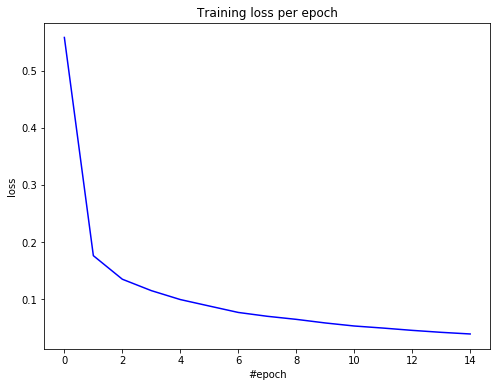

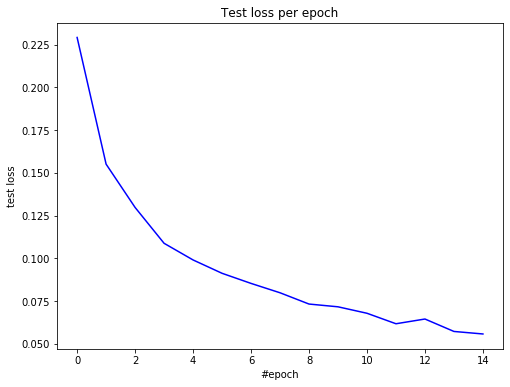

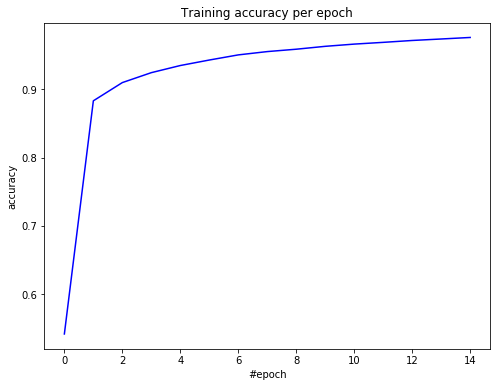

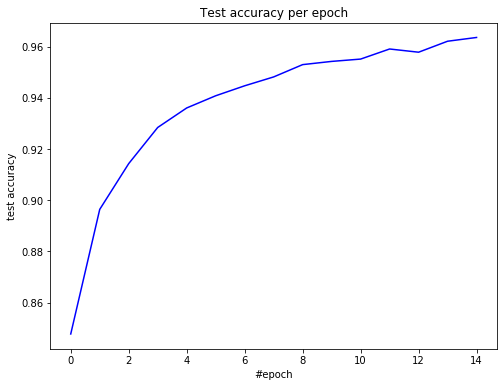

In [118]:
my_nn_2 = Sequential()
my_nn_2.add(Linear(784, 300))
my_nn_2.add(Sigmoid())
my_nn_2.add(Linear(300, 100))
my_nn_2.add(ReLU())
my_nn_2.add(Linear(100, 10))
my_nn_2.add(SoftMax())

criterion = MSECriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

batch_size = 120
epoch_number = 15

# train and test the model
train_loss, train_acc, test_loss, test_acc = train_with_test(X_train, y_train, X_test, y_test, my_nn_2, optimizer_config, optimizer_state, batch_size, epoch_number)

# Visualize loss
plt.figure(figsize=(8, 6))

plt.title("Training loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss, 'b')
plt.show()

# test loss
plt.figure(figsize=(8, 6))

plt.title("Test loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("test loss")
plt.plot(test_loss, 'b')
plt.show()

# Visualize accuracy
plt.figure(figsize=(8, 6))

plt.title("Training accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_acc, 'b')
plt.show()

plt.figure(figsize=(8, 6))

plt.title("Test accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("test accuracy")
plt.plot(test_acc, 'b')
plt.show()

## Previous NN with a dropout

Current epoch: 1
Current loss: 0.186158
Current accuracy: 0.870000
Current test loss: 0.231071
Current test accuracy: 0.841732
Current epoch: 2
Current loss: 0.154085
Current accuracy: 0.890000
Current test loss: 0.165480
Current test accuracy: 0.889048
Current epoch: 3
Current loss: 0.210502
Current accuracy: 0.860000
Current test loss: 0.150891
Current test accuracy: 0.899221
Current epoch: 4
Current loss: 0.125271
Current accuracy: 0.930000
Current test loss: 0.133256
Current test accuracy: 0.912035
Current epoch: 5
Current loss: 0.102706
Current accuracy: 0.930000
Current test loss: 0.115335
Current test accuracy: 0.924242
Current epoch: 6
Current loss: 0.060911
Current accuracy: 0.960000
Current test loss: 0.108374
Current test accuracy: 0.928442
Current epoch: 7
Current loss: 0.097386
Current accuracy: 0.920000
Current test loss: 0.101957
Current test accuracy: 0.932121
Current epoch: 8
Current loss: 0.188460
Current accuracy: 0.880000
Current test loss: 0.094300
Current test acc

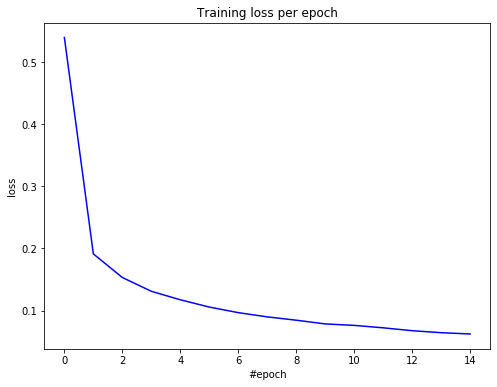

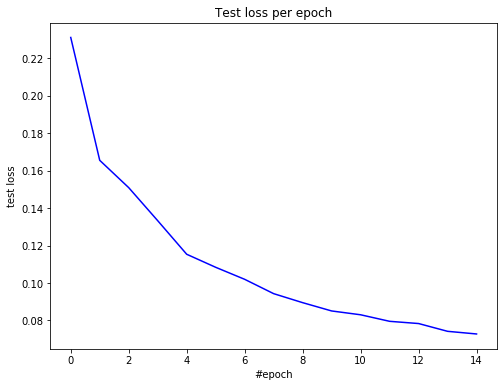

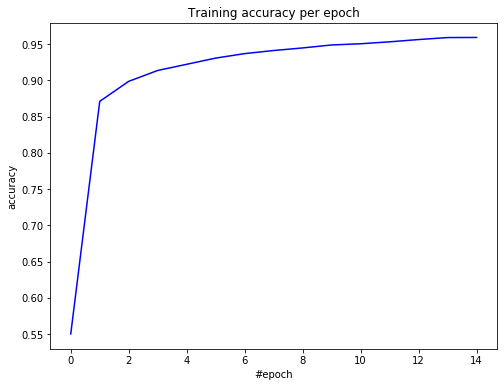

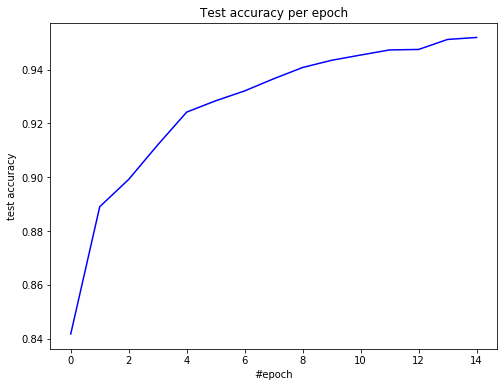

In [120]:
my_nn_3 = Sequential()
my_nn_3.add(Linear(784, 300))
my_nn_3.add(Sigmoid())
my_nn_3.add(Dropout(0.3)) # only this one was added to the previous model
my_nn_3.add(Linear(300, 100))
my_nn_3.add(ReLU())
my_nn_3.add(Linear(100, 10))
my_nn_3.add(SoftMax())

criterion = MSECriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

batch_size = 120
epoch_number = 15

# train and test the model
train_loss, train_acc, test_loss, test_acc = train_with_test(X_train, y_train, X_test, y_test, my_nn_3, optimizer_config, optimizer_state, batch_size, epoch_number)

# Visualize loss
plt.figure(figsize=(8, 6))

plt.title("Training loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_loss, 'b')
plt.show()

# test loss
plt.figure(figsize=(8, 6))

plt.title("Test loss per epoch")
plt.xlabel("#epoch")
plt.ylabel("test loss")
plt.plot(test_loss, 'b')
plt.show()

# Visualize accuracy
plt.figure(figsize=(8, 6))

plt.title("Training accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_acc, 'b')
plt.show()

plt.figure(figsize=(8, 6))

plt.title("Test accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("test accuracy")
plt.plot(test_acc, 'b')
plt.show()